<a href="https://colab.research.google.com/github/mirpouya/GANs/blob/main/Introduction_to_DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> 1. Downloading the Dataset </h1>

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pouyammsadeghi
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:02<00:00, 174MB/s]


In [ ]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [ ]:
print(os.listdir(DATA_DIR+'/images')[:10])

['13102_2005.jpg', '43420_2013.jpg', '27303_2009.jpg', '8530_2004.jpg', '49988_2015.jpg', '10343_2004.jpg', '53143_2016.jpg', '5067_2003.jpg', '4996_2003.jpg', '13682_2006.jpg']


<b> Visualizing some of the data <'/b>

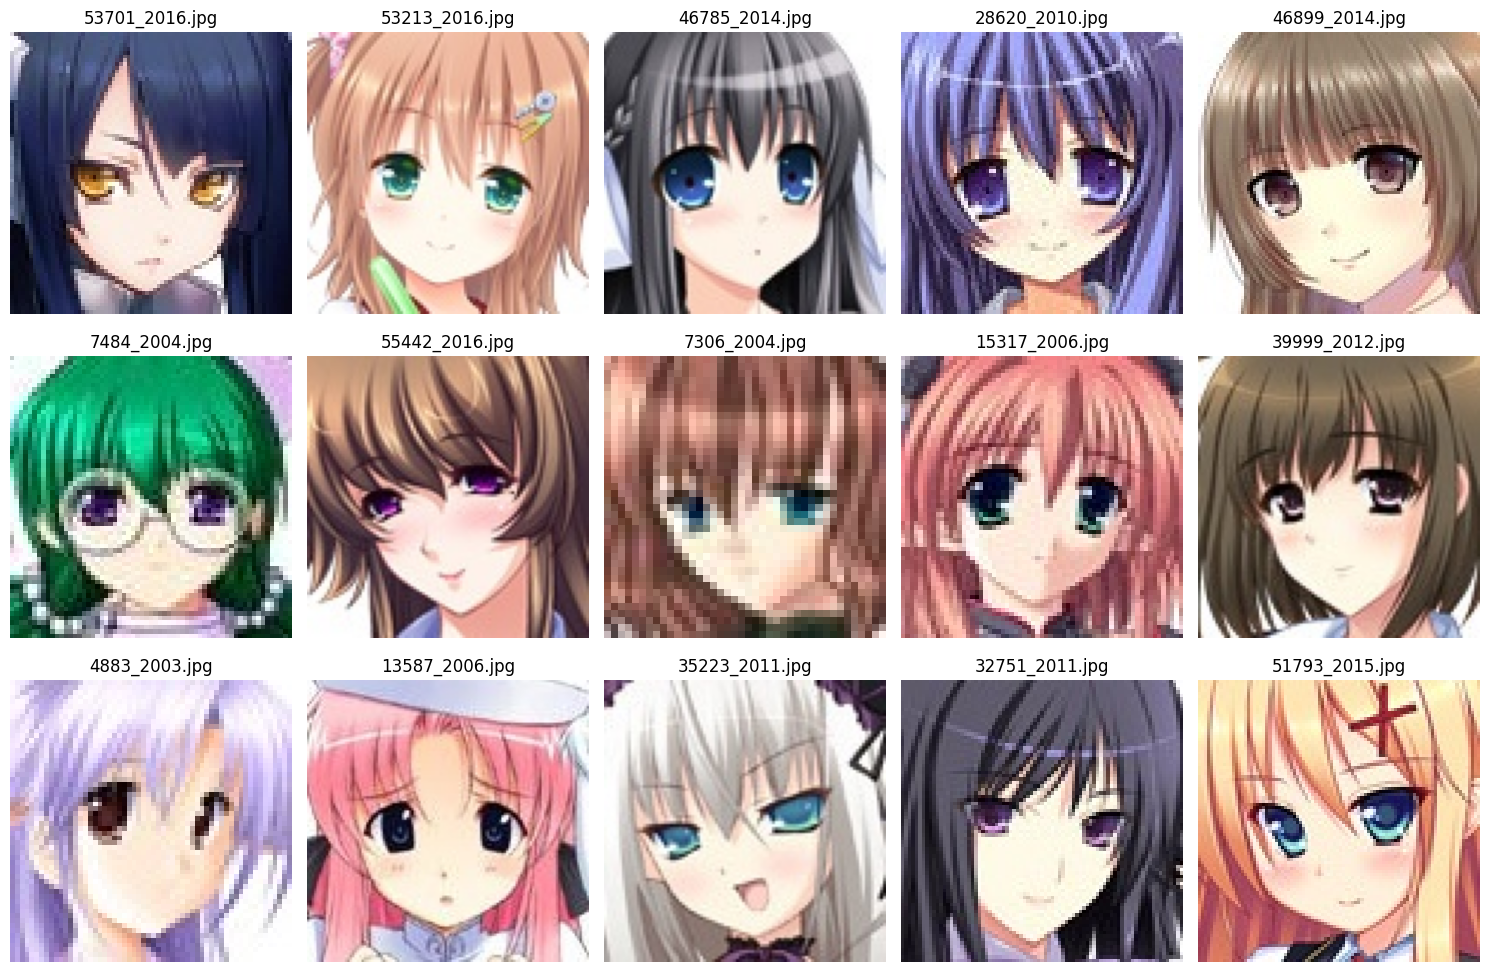

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Path to the directory containing the images
dataset_dir = "/content/animefacedataset/images"

# Get a list of all image files
image_files = os.listdir(dataset_dir)

# Select 15 random images
random_images = random.sample(image_files, 15)

# Define the size of the grid for subplots
rows = 3
cols = 5

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array to easily iterate over subplots
axes = axes.flatten()

# Loop through each random image and plot it
for i, image_name in enumerate(random_images):
    # Open the image
    image_path = os.path.join(dataset_dir, image_name)
    image = Image.open(image_path)

    # Plot the image on the corresponding subplot
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis

    # Set subplot title as the image filename
    axes[i].set_title(image_name)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
# DataLoader
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

<b> STEPS </B>
* RESIZE and CROP images to (64, 64)
* NORMALIZE pixel values in range of (-1, 1) in each channel
* create DATALOADER to load the data into batches

In [ ]:
image_size = 64
batch_size = 128

# normalizing with mean of 0.5 and std of 0.5 in each channel
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

<font color='blue'> <b> QUESTION: </b> </font>
what is ImageFolder used for?

In [ ]:
train_dataset = ImageFolder(
    DATA_DIR,
    transform = T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*stats)]
    )
)

In [ ]:
# DataLoader
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
# LIBRARIES
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

<h1> <b> Using GPU </b> </h1>

Defining a set of `helper functions` to:
* check availability of GPU
* Moving data to GPU
* Moving model to GPU <br>
if available

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

now with `DeviceDataLoader` we can automatically transfer data to the GPU

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

<h1> <b> 2. Discriminator Network </b> </h1>

Discriminator network is a CNN with binary output, it determines if an image is real or generated by Generator network. In this sense, it is like any other conventional image classifier like VGG16, ResNet, InceptionNet, ...

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)`

<b> output shape of a convolutional layer </b>

$ \large \text{Output size} = \frac{\text{Input size} + 2 \times \text{padding} - \text{kernel size} - 1}{\text{stride}} + 1 $


In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

<b> LeakyReLU activation function: </b>

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">

In [ ]:
# moving discriminator to GPU if available

discriminator = to_device(discriminator, device)

<h1> <b> 3. Generator Network </b> </h1>

The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [ ]:
latent_size = 128

`torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)`

$ \large \text{Output size} = (\text{Input size} - 1) \times \text{stride} - 2 \times \text{padding} + \text{kernel size} + \text{output padding} $

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

The last layer has `tanh` activation for mapping input between (-1, 1) since in the normalization process we normalize pixel values in the range of (-1, 1)

NOTE another time that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

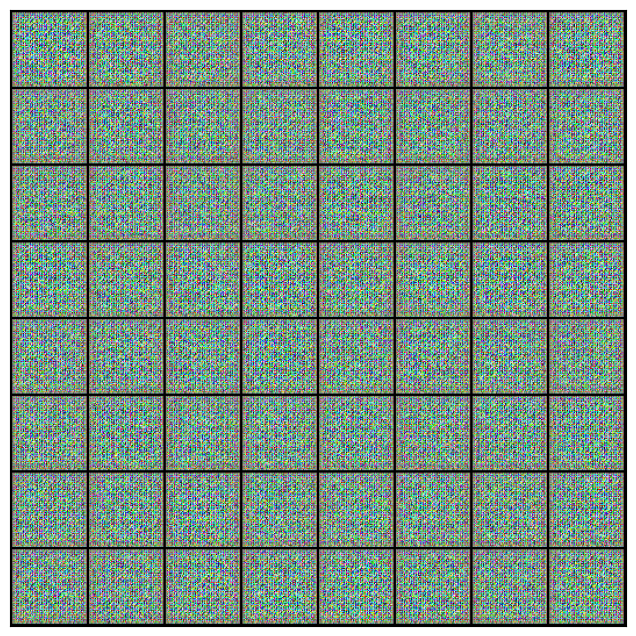

In [ ]:
# making randonm latent tensors
xb = torch.randn(batch_size, latent_size, 1, 1)

fake_images = generator(xb)
show_images(fake_images)

In [ ]:
# move generator to GPU if available
generator = to_device(generator, device)

<h1> <b> 4. Discriminator Training </b> </h1>

Discriminator is a binary classification, therefore we can use the binary cross entropy loss for its training.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

<h1> <b> 5. Generator Training </b> </h1>

The output of generator is some images or noises, hence it is difficult to define a directl loss function for measuring it is doing good. As a result, we need to employ an indirect way of performance measurement and training

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


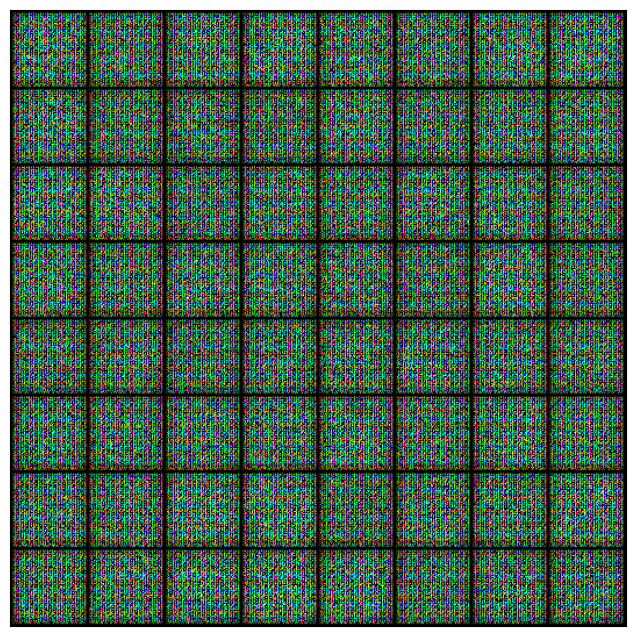

In [ ]:
save_samples(0, fixed_latent)

<h1> <b> 7. Full Training loop </b> </h1>

Purpose of `fit` function is to train both generator and disrciminator in tandemn together.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 3.0161, loss_d: 0.5360, real_score: 0.6607, fake_score: 0.0459
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.0591, loss_d: 0.3768, real_score: 0.9165, fake_score: 0.2299
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 6.8647, loss_d: 0.3374, real_score: 0.7644, fake_score: 0.0034
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.2302, loss_d: 0.1797, real_score: 0.9354, fake_score: 0.0889
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 8.2529, loss_d: 0.2865, real_score: 0.9844, fake_score: 0.2027
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 4.7717, loss_d: 0.0846, real_score: 0.9565, fake_score: 0.0341
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 6.1951, loss_d: 0.0845, real_score: 0.9352, fake_score: 0.0102
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 6.9165, loss_d: 0.1539, real_score: 0.9763, fake_score: 0.1113
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 6.2597, loss_d: 0.1229, real_score: 0.9334, fake_score: 0.0444
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 4.3846, loss_d: 0.1202, real_score: 0.9330, fake_score: 0.0388
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 18.0150, loss_d: 1.1741, real_score: 1.0000, fake_score: 0.4991
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 22.3959, loss_d: 1.5258, real_score: 0.9999, fake_score: 0.6195
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 5.3175, loss_d: 0.1925, real_score: 0.8920, fake_score: 0.0410
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 6.1256, loss_d: 0.0977, real_score: 0.9926, fake_score: 0.0803
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 5.6898, loss_d: 0.1635, real_score: 0.9449, fake_score: 0.0882
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.6413, loss_d: 0.1061, real_score: 0.9725, fake_score: 0.0634
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 5.6194, loss_d: 0.0617, real_score: 0.9669, fake_score: 0.0199
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 20.0317, loss_d: 6.0333, real_score: 1.0000, fake_score: 0.9353
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 10.1783, loss_d: 0.3197, real_score: 0.8067, fake_score: 0.0001
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 6.0775, loss_d: 0.1098, real_score: 0.9840, fake_score: 0.0704
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 4.9116, loss_d: 0.0872, real_score: 0.9494, fake_score: 0.0185
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 6.0289, loss_d: 0.0276, real_score: 0.9842, fake_score: 0.0100
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 6.8278, loss_d: 0.0523, real_score: 0.9650, fake_score: 0.0065
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 6.0453, loss_d: 0.0481, real_score: 0.9764, fake_score: 0.0214
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 21.1670, loss_d: 0.0007, real_score: 0.9993, fake_score: 0.0000
Saving generated-images-0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

<b> Saving the model's checkpoints </b>

In [ ]:
torch.save(generator.state_dict(), "Generator.pth")
torch.save(discriminator.state_dict(), "Discriminator.pth")

<h3> <b> Visualizing generator's outputs after 1st, 5th, and 10th epochs of training </b> </h3>

In [ ]:
from IPython.display import Image

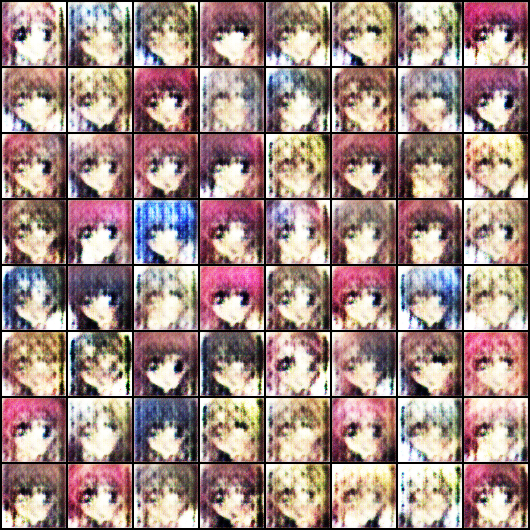

In [ ]:
Image('./generated/generated-images-0001.png')

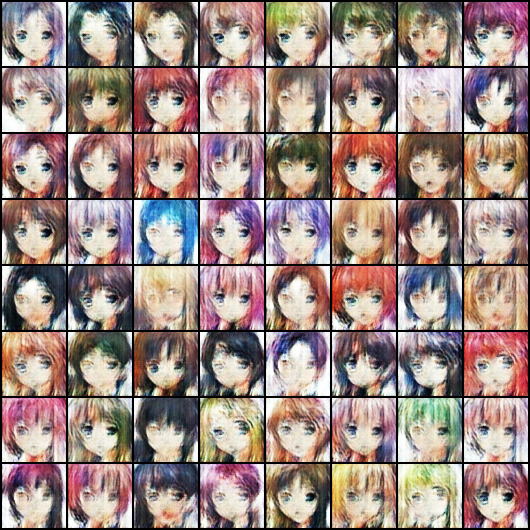

In [ ]:
Image('./generated/generated-images-0005.png')

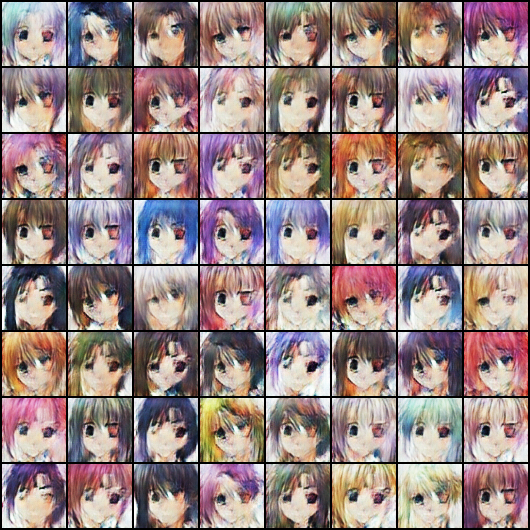

In [ ]:
Image('./generated/generated-images-0010.png')

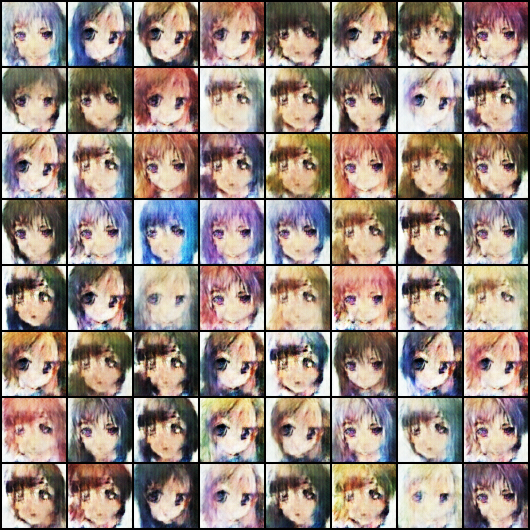

In [ ]:
Image('./generated/generated-images-0020.png')

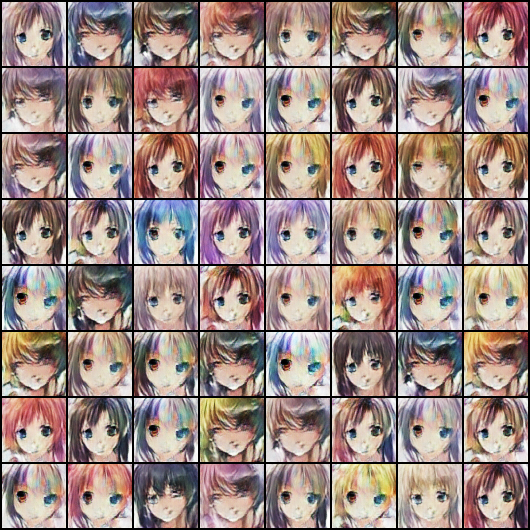

In [ ]:
Image('./generated/generated-images-0025.png')

<h3> <b> Visualizing training process </b> </h3>

In [ ]:
import cv2
import os

video_file_name = "GAN_training.avi"

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(video_file_name,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

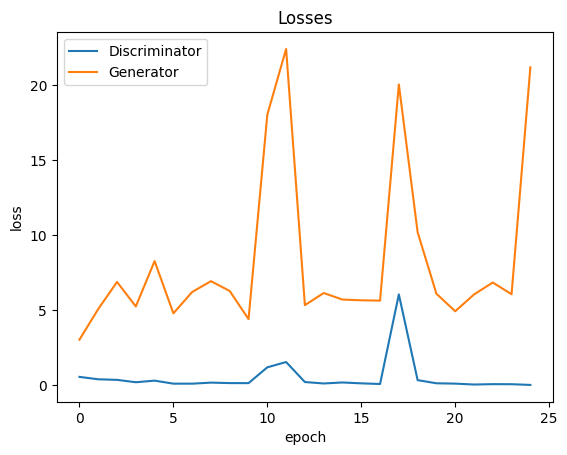

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

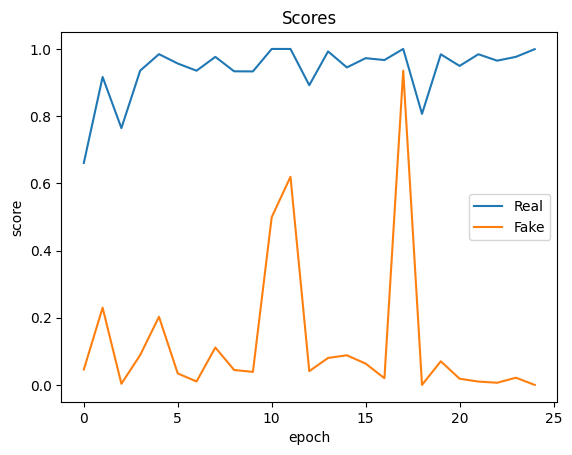

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');